In [4]:
import tweepy
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from config import consumer_key, consumer_secret, access_token, access_token_secret

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

#list of the news outlet - on Tweeter 
news_outlets=['BBC', 'CBS', 'CNN', 'FoxNews' , 'nytimes'] 

#Initiating and empty table to hold data from twitter   
cols=['Tweets', 'Followers', 'Following', 'Favorites Count']
popular_news= pd.DataFrame(index=news_outlets ,columns=cols).reset_index()
popular_news=popular_news.rename(columns = {'index':'Screen Name'})

In [5]:
# Iterate through DataFrame
for index, row in popular_news.iterrows():
    try:
        # Grab the username
        target_user = row["Screen Name"]
        # print(target_user)

        # Use the username with the Twitter API get_user
        user_account = api.get_user(target_user)
        user_real_name = user_account["name"]

        # Get the specific column data
        user_tweets = user_account["statuses_count"]
        user_followers = user_account["followers_count"]
        user_following = user_account["friends_count"]
        user_favorites = user_account["favourites_count"]

        # Replace the row information for each
        popular_news.set_value(index, "Real Name", user_real_name)
        popular_news.set_value(index, "Tweets", user_tweets)
        popular_news.set_value(index, "Followers", user_followers)
        popular_news.set_value(index, "Following", user_following)
        popular_news.set_value(index, "Favorites Count", user_favorites)

    except tweepy.TweepError as e:
        print(e)
        
#set index with Real Name for nice ploting 
popular_news.set_index('Real Name', inplace=True)

# making dir for porper label real name vs. screen name 

real_name=popular_news.reset_index()['Real Name'].tolist()
scre_name=popular_news.reset_index()['Screen Name'].tolist()

real_name_dir={}

for i in range(len(real_name)):
    real_name_dir[scre_name[i]]=real_name[i]

real_name_dir

{'BBC': 'BBC',
 'CBS': 'CBS',
 'CNN': 'CNN',
 'FoxNews': 'Fox News',
 'nytimes': 'The New York Times'}

In [6]:
# Target User
#news_outlets =('BBC', 'CBS', 'CNN', 'FoxNews', 'nytimes', 'washingtonpost' ) 

#Create Dir to hold extracted data 
sentement_scores={}

for news_outlet in news_outlets:

    # Place holders 
    date_time=[]
    tweet_texts =[]
    compounds=   [] 
    neg_score=   []
    pos_score=   []
    neu_score=   []
    tweet_num=   []

    # Create a loop to iteratively run API requests
    num=1
    for tweet_page in range(1,6):

        # Get all tweets from home feed (for each page specified)
        public_tweets = api.user_timeline(news_outlet, page=tweet_page)

        # Loop through all tweets
        for tweet in public_tweets:


            # tweet Number 
            tweet_num.append(num)
            num+=1
            # Print Tweet
            #print(tweet["text"])
            
            #extract date 
            date_time.append(tweet['created_at'])

            # Store Tweet in Array
            tweet_texts.append(tweet["text"])
            
            # store veda in array 
            compound=analyzer.polarity_scores(tweet["text"])['compound']
            
            #print(compound)
            compounds.append(compound)
            
            neg=analyzer.polarity_scores(tweet["text"])['neg']
            neg_score.append(neg)
            
            # print most neg news
            if neg > .5:
                print(tweet["text"])
                print(news_outlet)
                print(f'Negative News Score (0 to 1) : {neg}')
                print('__')
                

            
            pos=analyzer.polarity_scores(tweet["text"])['pos']
            pos_score.append(pos)
            
            # print most pos news 
            if pos > .5:
                print(tweet["text"])
                print(news_outlet)
                print(f'Positive News Score (0 to 1): {pos}')
                print('__')
            
            neu=analyzer.polarity_scores(tweet["text"])['neu']
            neu_score.append(neu)
    
    #Dirctory with all data for the current news outlet 
    sentement_scores[news_outlet]=(tweet_num, date_time, compounds, neg_score, pos_score, neu_score, tweet_texts)

Wow! 19-year-old Justice Osei from Ghana has an amazing talent for imitating animals. 🐊🐢🐒🦇🐇🐿🐓🐑🐸🦆🦎
https://t.co/UZqeSyzsQB
BBC
Positive News Score (0 to 1): 0.562
__
RT @KelseaBallerini: Ohhhhh goodness. Incredible. Thank you thank you thank you. #female https://t.co/1ZTYjNfQeF
CBS
Positive News Score (0 to 1): 0.538
__
A man has been arrested for allegedly threatening to assault and murder a congressman from Virginia… https://t.co/2zCfq5BD0E
CNN
Negative News Score (0 to 1) : 0.577
__


In [10]:
# a function to to make data frame for each news outlet data 

def pol_df(news_outlet):
    scores={'Tweet_number': sentement_scores[news_outlet][0],
            'Date':sentement_scores[news_outlet][1],
            'Compound':sentement_scores[news_outlet][2],
            'Negative':sentement_scores[news_outlet][3],
            'Positive':sentement_scores[news_outlet][4],
            'Neutral':sentement_scores[news_outlet][5],
            'Tweet':sentement_scores[news_outlet][6],
            'News_outlet': news_outlet
           }
    return(pd.DataFrame(scores))

# create empty data frame 
cols=['News_outlet', 'Tweet_number', 'Date', 'Positive',  'Negative', 'Neutral', 'Compound', 'Tweet']
news_outlets_sentements = pd.DataFrame(columns=cols)

for news_outlet in news_outlets:
    news_outlet_data=pol_df(news_outlet)
    news_outlets_sentements = news_outlets_sentements.append(news_outlet_data)
    
news_outlets_sentements.reset_index(drop=True, inplace=True)

raw_date=news_outlets_sentements['Date'].tolist()
dates=[datetime.strptime(raw_stamp, "%a %b %d %H:%M:%S %z %Y") for raw_stamp in raw_date]
dates_array=np.asarray(dates)
#pd.Series(test3)
news_outlets_sentements.insert(0, 'Date_time', dates_array)


#drop old raw date 
news_outlets_sentements.drop('Date', axis=1, inplace=True)

#QC Step 
news_outlets_sentements.head()

,Date_time,Compound,Negative,Neutral,News_outlet,Positive,Tweet,Tweet_number
0,2018-03-23 19:07:00+00:00,0.000,0.000,1.000,BBC,0.0,"RT @BBCOne: .@GaryLineker, @OreOduba, @ThisisD...",1
1,2018-03-23 18:03:04+00:00,-0.296,0.136,0.864,BBC,0.0,From @taylorswift13 to @Beyonce: these are the...,2
2,2018-03-23 17:33:03+00:00,0.000,0.000,1.000,BBC,0.0,"Tonight, @GaryLineker, @ThisisDavina and @OreO...",3
3,2018-03-23 17:02:01+00:00,0.000,0.000,1.000,BBC,0.0,"Your week, as told by @louistheroux. 📆😂\nhttps...",4
4,2018-03-23 16:27:45+00:00,0.000,0.000,1.000,BBC,0.0,RT @BBCWales: A #DanceForParkinsons session wi...,5


In [11]:
news_outlets_sentements['News_outlet'] = news_outlets_sentements['News_outlet'].map(real_name_dir)
news_outlets_sentements

,Date_time,Compound,Negative,Neutral,News_outlet,Positive,Tweet,Tweet_number
0,2018-03-23 19:07:00+00:00,0.0000,0.000,1.000,BBC,0.000,"RT @BBCOne: .@GaryLineker, @OreOduba, @ThisisD...",1
1,2018-03-23 18:03:04+00:00,-0.2960,0.136,0.864,BBC,0.000,From @taylorswift13 to @Beyonce: these are the...,2
2,2018-03-23 17:33:03+00:00,0.0000,0.000,1.000,BBC,0.000,"Tonight, @GaryLineker, @ThisisDavina and @OreO...",3
3,2018-03-23 17:02:01+00:00,0.0000,0.000,1.000,BBC,0.000,"Your week, as told by @louistheroux. 📆😂\nhttps...",4
4,2018-03-23 16:27:45+00:00,0.0000,0.000,1.000,BBC,0.000,RT @BBCWales: A #DanceForParkinsons session wi...,5
5,2018-03-23 16:00:12+00:00,0.7783,0.000,0.714,BBC,0.286,"Meet Australian maths teacher Eddie Woo, who h...",6
6,2018-03-23 14:33:40+00:00,-0.4479,0.172,0.828,BBC,0.000,"RT @BBCOne: No @andy_murray, this is not a dre...",7
7,2018-03-23 14:03:08+00:00,0.5994,0.000,0.813,BBC,0.187,These beautiful photographs reveal how refugee...,8
8,2018-03-23 14:00:02+00:00,-0.4767,0.129,0.871,BBC,0.000,How would you react if you woke up and found M...,9
9,2018-03-23 13:33:04+00:00,0.6114,0.000,0.800,BBC,0.200,Spring is here! 🌱🌸🥦 Make the most of seasonal ...,10


In [12]:
news_outlets_sentements.to_csv('news_outlets_sentements.csv')

In [13]:
# dates for disply 
dates=news_outlets_sentements.Date_time.sort_values()
date_1st=dates.iloc[0]
date_end=dates.iloc[-1]
date_1st

date_start=f'{date_1st.month}/{date_1st.day}/{date_1st.year} {date_1st.hour}:{date_1st.minute}'
date_end=f'{date_end.month}/{date_end.day}/{date_end.year} {date_end.hour}:{date_end.minute}'

compund=news_outlets_sentements.pivot(index='Tweet_number', columns='News_outlet', values='Compound')

# Sentiment analysis for each news outlet

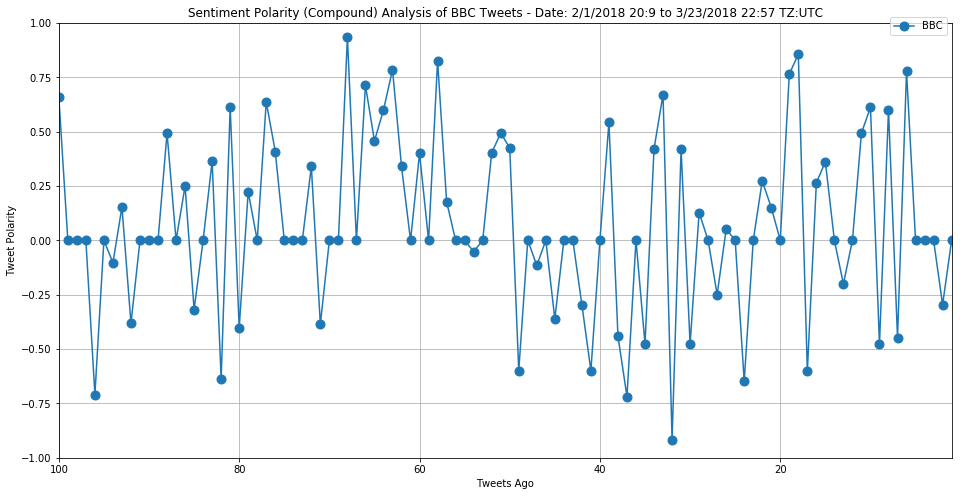

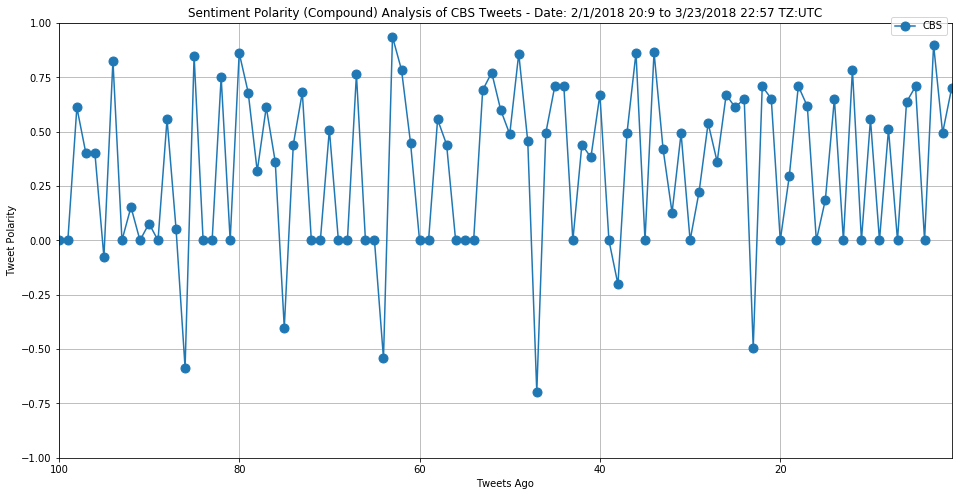

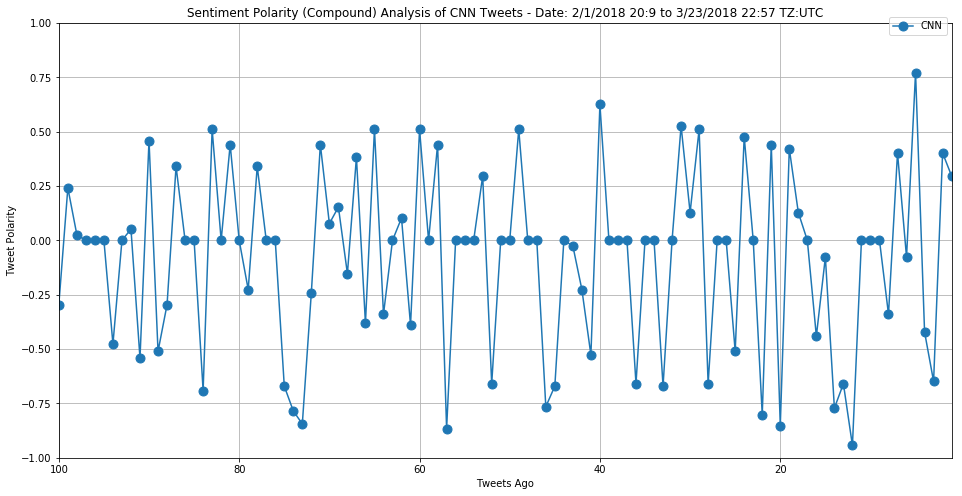

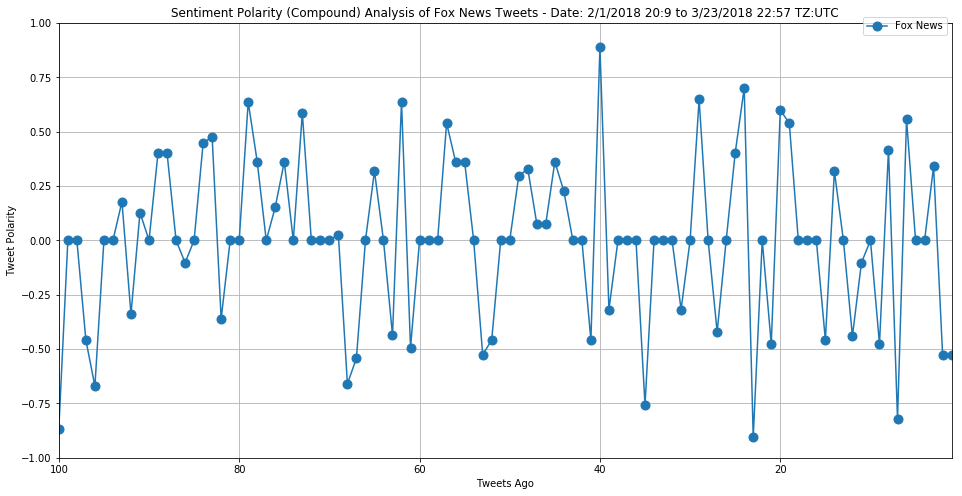

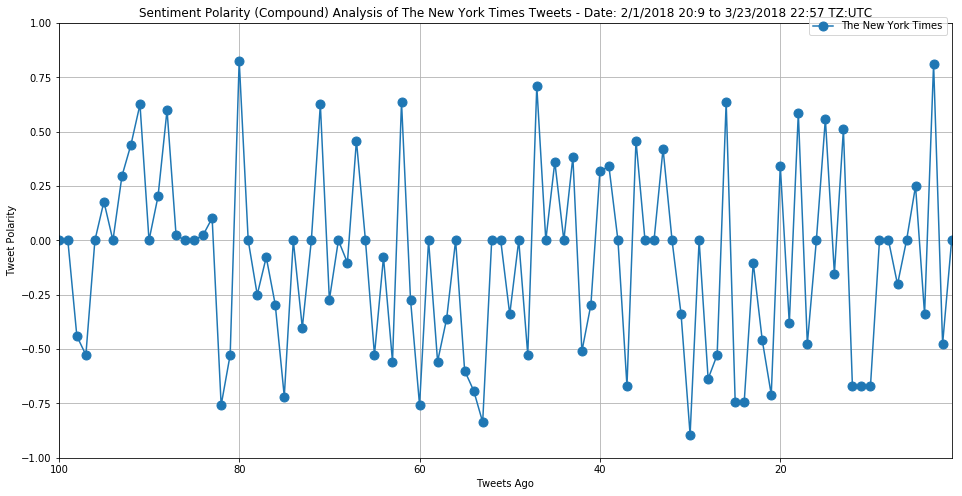

In [14]:
news_outlets=real_name
for news_outlet in news_outlets:
    compund[news_outlet].sort_index(ascending=False).plot(marker = 'o', grid=True,style='-', ms=9, figsize=(16,8))
    plt.legend(bbox_to_anchor=(1, 1.025))
    plt.xlabel('Tweets Ago')
    plt.ylabel('Tweet Polarity')
    plt.title(f'Sentiment Polarity (Compound) Analysis of {news_outlet} Tweets - Date: {date_start} to {date_end} TZ:UTC')
    plt.ylim(-1,1)
    plt.savefig(f'Sentiment Polarity Analysis {news_outlet}')

    plt.show();

# Sentiment Analysis for all news outlets

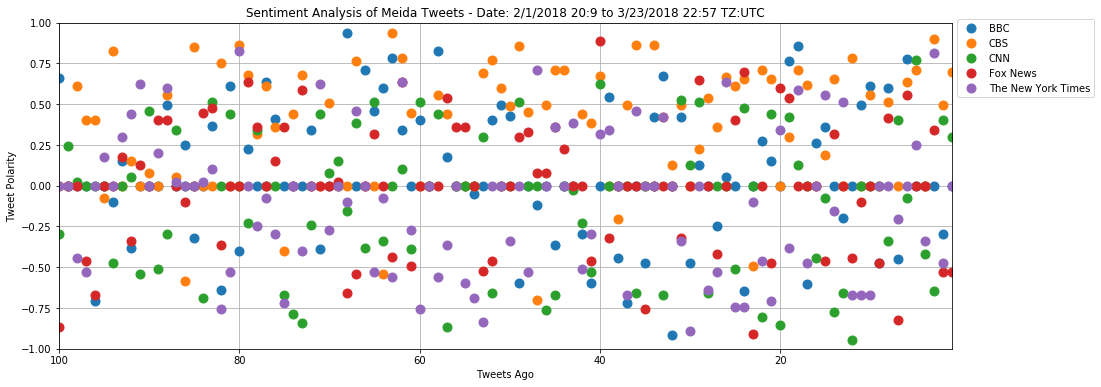

In [15]:
compund.sort_index(ascending=False).plot(marker = 'o', grid=True,style=' ', ms=9, figsize=(16,6))
plt.legend(bbox_to_anchor=(1, 1.025))
plt.xlabel('Tweets Ago')
plt.ylabel('Tweet Polarity')
plt.title(f'Sentiment Analysis of Meida Tweets - Date: {date_start} to {date_end} TZ:UTC')
plt.ylim(-1,1)
plt.savefig('Sentiment Polarity Analysis all news outlets')

plt.show();

In [22]:
summary_df = news_outlets_sentements.groupby('News_outlet').mean()
summary_df

,Compound,Negative,Neutral,Positive
News_outlet,,,,
BBC,0.071703,0.05129,0.86663,0.08207
CBS,0.327685,0.01892,0.84401,0.13706
CNN,-0.081560,0.08244,0.86826,0.04929
Fox News,0.002235,0.06236,0.87306,0.06459
The New York Times,-0.094181,0.08809,0.85440,0.05751


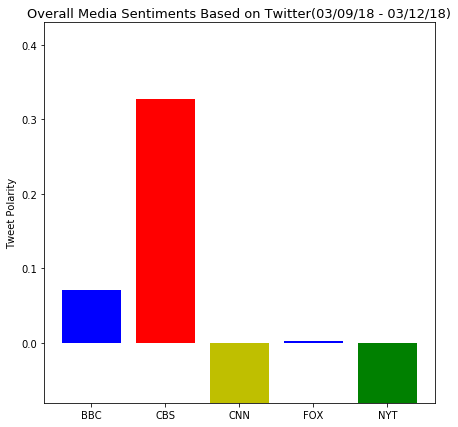

In [23]:
x =  {
    "BBC" : np.mean(summary_df['Compound'][0]), 
    "CBS" : np.mean(summary_df['Compound'][1]),
    "CNN" : np.mean(summary_df['Compound'][2]),
    "FOX": np.mean(summary_df['Compound'][3]),
    "NYT": np.mean(summary_df['Compound'][4]) }

plt.figure(figsize = (7,7))
plt.bar(x.keys(), x.values(), color = ['b', 'r', 'y', 'b', 'g'])
plt.title('Overall Media Sentiments Based on Twitter(03/09/18 - 03/12/18)', fontsize = 13)
plt.ylabel("Tweet Polarity")
plt.ylim(-0.08, 0.43)
plt.show()
plt.savefig('BarGraph')